## Parsing the CSSE Daily Data for COVID 19:
https://github.com/CSSEGISandData/COVID-19

Using the code provided by Prof. James Sharpnack
https://github.com/jsharpna/CovidResponse208

The population dataset is from the 2019 census

and 
## Parsing the social Distancing data from Safegraph


In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid

plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, losses

from patsy import dmatrices
import statsmodels.api as sm
from sklearn.metrics import r2_score


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')


TensorFlow version: 2.1.0
Eager execution: True


In [2]:
#importing the train set
X_tr = pd.read_csv('../data/X_tr.csv')   
y_tr = pd.read_csv('../data/y_tr.csv') 
print(X_tr.shape)
print(y_tr.shape)

(3573, 5)
(3573, 2)


In [3]:
# only keeping the data where incident rate is more than 0.5
X_tr = X_tr[y_tr['Incident_Rate'] >= 0.5]
y_tr = y_tr[y_tr['Incident_Rate'] >= 0.5]

In [4]:
X_tr.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
157,2020-02-21,Nebraska,1934408.0,0,19.236149
265,2020-03-04,Washington,7614893.0,0,23.675703
282,2020-03-05,Washington,7614893.0,1,24.347069
307,2020-03-06,Washington,7614893.0,2,24.577092
337,2020-03-07,Washington,7614893.0,3,27.524526


In [5]:
train_timestamps = X_tr['Date'].values
train_timestamps[:5]


array(['2020-02-21', '2020-03-04', '2020-03-05', '2020-03-06',
       '2020-03-07'], dtype=object)

In [6]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
print(X_tr.shape)
print(y_tr.shape)

(2920, 4)
(2920, 1)


In [7]:
X_tr.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
157,Nebraska,1934408.0,0,19.236149
265,Washington,7614893.0,0,23.675703
282,Washington,7614893.0,1,24.347069
307,Washington,7614893.0,2,24.577092
337,Washington,7614893.0,3,27.524526


In [8]:
X_tr.describe()

,Population,Elapsed_Days,Percentage_Home
count,2.920000e+03,2920.000000,2920.000000
mean,6.420689e+06,27.018493,37.653490
std,7.291724e+06,16.636420,6.623412
min,5.787590e+05,0.000000,17.885169
25%,1.787065e+06,13.000000,32.934542
50%,4.467673e+06,27.000000,37.216028
75%,7.614893e+06,41.000000,41.818998
max,3.951222e+07,66.000000,69.594465


In [9]:
X_tr[X_tr.isnull().values == True].head()

,Province_State,Population,Elapsed_Days,Percentage_Home


In [10]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 157 to 3572
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Province_State   2920 non-null   object 
 1   Population       2920 non-null   float64
 2   Elapsed_Days     2920 non-null   int64  
 3   Percentage_Home  2920 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 114.1+ KB


In [11]:
#standardizer function which standardizes the numerical data and encodes the categorical data with LabelEncoder
def standardize_fit1 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:4]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = LabelEncoder()
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    classes= encoder.classes_

    return classes, scaler, encoder 

def standardize_transfrom1( Xin, scaler, encoder):
    X = Xin.values[:,1:4]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X).reshape(-1, 1)
    return np.concatenate((X_std_cat, X_std_num),axis=1)


classes, scaler, encoder1 = standardize_fit1(X_tr)
X_tr_std1 = standardize_transfrom1(X_tr, scaler, encoder1)
print(classes)


['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [12]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:4]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:4]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)


categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std2 = standardize_transfrom2(X_tr, scaler, encoder2)
print(categories)


[array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)]


In [13]:
X_tr_std = X_tr_std1
print(X_tr_std.shape)
print(X_tr_std[:5,:])

(2920, 4)
[[27.         -0.6153619  -1.62433509 -2.78111875]
 [48.          0.16380336 -1.62433509 -2.11072188]
 [48.          0.16380336 -1.56421571 -2.00934203]
 [48.          0.16380336 -1.50409633 -1.97460725]
 [48.          0.16380336 -1.44397695 -1.5295287 ]]


In [14]:
pd.DataFrame(X_tr_std).describe()

,0,1,2,3
count,2920.000000,2.920000e+03,2.920000e+03,2.920000e+03
mean,25.510959,-2.676702e-17,-7.786770e-17,-8.760116e-17
std,15.004072,1.000171e+00,1.000171e+00,1.000171e+00
min,0.000000,-8.013099e-01,-1.624335e+00,-2.985124e+00
25%,12.750000,-6.355722e-01,-8.427831e-01,-7.125868e-01
50%,26.000000,-2.678859e-01,-1.111797e-03,-6.605907e-02
75%,38.250000,1.638034e-01,8.405595e-01,6.290144e-01
max,51.000000,4.539009e+00,2.343544e+00,4.823261e+00


In [15]:
y_tr.head()

,Incident_Rate
157,0.568649
265,0.538419
282,0.945516
307,1.116234
337,1.444538


In [16]:
y_tr.describe()

,Incident_Rate
count,2920.000000
mean,139.077962
std,232.835254
min,0.503619
25%,16.006792
50%,60.191737
75%,145.736850
max,1712.395998


In [17]:
y_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 157 to 3572
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Incident_Rate  2920 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


In [18]:
#importing the test set
X_te = pd.read_csv('../data/X_te.csv')   
y_te = pd.read_csv('../data/y_te.csv') 
print(X_te.shape)
print(y_te.shape)

(832, 5)
(832, 2)


In [19]:
X_te.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
0,2020-05-10,Alabama,4903185.0,55,26.622293
1,2020-05-10,Alaska,731545.0,53,33.555901
2,2020-05-10,Arizona,7278717.0,52,38.224841
3,2020-05-10,Arkansas,3017804.0,56,26.700268
4,2020-05-10,California,39512223.0,59,40.783996


In [20]:
X_te[X_te.isnull().values == True].head()


,Date,Province_State,Population,Elapsed_Days,Percentage_Home
780,2020-05-25,Alabama,4903185.0,70,NaN
781,2020-05-25,Alaska,731545.0,68,NaN
782,2020-05-25,Arizona,7278717.0,67,NaN
783,2020-05-25,Arkansas,3017804.0,71,NaN
784,2020-05-25,California,39512223.0,74,NaN


In [21]:
#dropping NaNs from the test set
y_te = y_te[~X_te['Percentage_Home'].isnull() == True]
X_te = X_te[~X_te['Percentage_Home'].isnull() == True]
X_te[X_te.isnull().values == True]

,Date,Province_State,Population,Elapsed_Days,Percentage_Home


In [22]:
# only keeping the data where incident rate is more than 0.5
X_te = X_te[y_te['Incident_Rate'] >= 0.5]
y_te = y_te[y_te['Incident_Rate'] >= 0.5]


In [23]:
test_timestamps = X_te['Date'].values
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)
print(X_te.shape)
print(y_te.shape)

(780, 4)
(780, 1)


In [24]:
X_te.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
0,Alabama,4903185.0,55,26.622293
1,Alaska,731545.0,53,33.555901
2,Arizona,7278717.0,52,38.224841
3,Arkansas,3017804.0,56,26.700268
4,California,39512223.0,59,40.783996


In [25]:
#standardizing the test data from the previously fitted standardizers
X_te_std1 = standardize_transfrom1(X_te, scaler, encoder1)
X_te_std2 = standardize_transfrom2(X_te, scaler, encoder2)
X_te_std = X_te_std1
print(X_te_std.shape)
print(X_te_std[:5,:])

(780, 4)
[[ 0.         -0.2081488   1.68223088 -1.6657707 ]
 [ 1.         -0.78035293  1.56199212 -0.6187582 ]
 [ 2.          0.11769169  1.50187274  0.08627717]
 [ 3.         -0.4667576   1.74235026 -1.65399616]
 [ 4.          4.53900928  1.92270841  0.47272356]]


In [26]:
pd.DataFrame(X_te_std).describe()

,0,1,2,3
count,780.000000,780.000000,780.000000,780.000000
mean,25.500000,-0.006443,2.092661,-0.510658
std,15.017961,0.992539,0.609364,0.899487
min,0.000000,-0.801310,-1.624335,-2.526564
25%,12.750000,-0.635049,1.922708,-1.158995
50%,25.500000,-0.285027,2.163186,-0.649169
75%,38.250000,0.129220,2.403663,0.076310
max,51.000000,4.539009,3.245335,3.298511


In [27]:
y_te.describe()

,Incident_Rate
count,780.000000
mean,402.180122
std,390.947895
min,42.852678
25%,160.799613
50%,246.760960
75%,478.752059
max,1858.348711


## Designing our regression models

without any delays

1- Random Forests Regression

2- Support Vector Machine Regression 

3- Poission Regression

4- MLP Regression based on the negative binomial loss function and Adam Optimizer

In [28]:
X = X_tr_std
y = y_tr.values

Xt = X_te_std
yt = y_te.values

X = np.asarray(X).astype(np.float64)
y = np.asarray(y).astype(np.float64)
Xt = np.asarray(Xt).astype(np.float64)
yt = np.asarray(yt).astype(np.float64)

# Random Forest Regressor

In [29]:
params = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [4, 8, 12, 16, 20, 32, 64]
}
best_score = -np.Inf 
rf = RandomForestRegressor()
for g in ParameterGrid(params):
    rf.set_params(**g)
    rf.fit(X, y)
    # save if best
    score = rf.score(Xt, yt)
    if score > best_score:
        best_score = score
        best_grid = g

print("r2 score: %0.5f" % best_score )
print("Grid:", best_grid)
rf.set_params(**best_grid)
rf.fit(X, y)
y_pred = rf.predict(Xt)


r2 score: 0.59617
Grid: {'max_depth': 20, 'n_estimators': 10}


In [30]:
calid = [i for i, x in enumerate(classes) if x == 'California']
print(calid)
calidx = [X_te_std[:,0] == calid ]
print (y_pred[calidx])

[4]
[276.83640181 243.19204214 209.3009725  246.40952989 276.83640181
 317.26210103 204.00199011 701.19266097 244.96389891 210.01293429
 235.19346392 247.1997487  317.26210103 317.26210103 204.00199011]


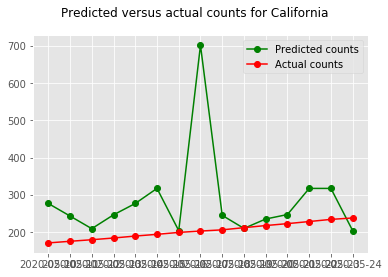

<Figure size 432x288 with 0 Axes>

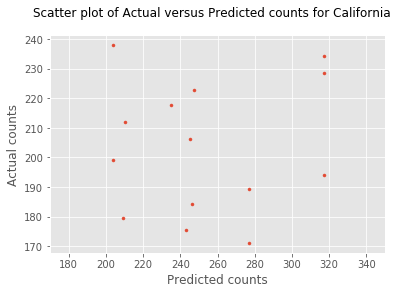

In [32]:
#Plot the predicted counts versus the actual counts for the test data for california.

fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.xlim((170, 350))
plt.show()

# Support Vector Machine Regressor

In [34]:
params = {
    "C" : [0.01, 0.1, 0.2, 0.5, 1, 2, 5],
    "kernel" : ["rbf","poly","sigmoid", "linear"],
    "gamma" : ["scale"]
}

best_score = -np.Inf 
svm = SVR()
for g in ParameterGrid(params):
    svm.set_params(**g)
    svm.fit(X, y)
    # save if best
    score = svm.score(Xt, yt)
    if score > best_score:
        best_score = score
        best_grid = g

print("r2 score: %0.5f" % best_score )
print("Grid:", best_grid)
svm.set_params(**best_grid)
svm.fit(X, y)
y_pred = svm.predict(Xt)

r2 score: -0.26623
Grid: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}


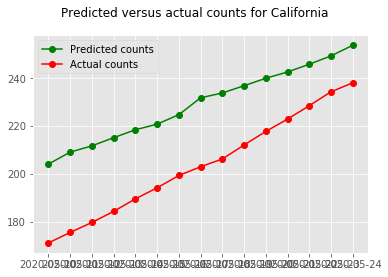

<Figure size 432x288 with 0 Axes>

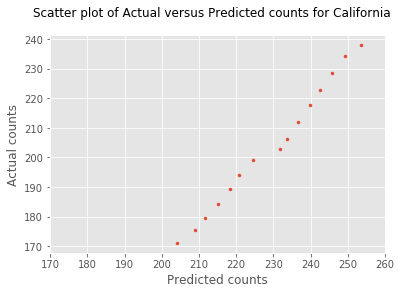

In [36]:
#Plot the predicted counts versus the actual counts for the test data for california.

fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.xlim((170, 260))
plt.show()

# Poisson Regression on General linear Models

In [41]:
# poisson regression from TowardsDataScience at
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(Xt)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

y_pred = predictions_summary_frame['mean'].values
print("the R2 score is ", r2_score(y_true= yt, y_pred= y_pred))


Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2920
Model:                            GLM   Df Residuals:                     2916
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.0288e+05
Date:                Thu, 28 May 2020   Deviance:                   1.1893e+06
Time:                        05:17:57   Pearson chi2:                 3.46e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0799      0.000    739.022      0.000       0.080   

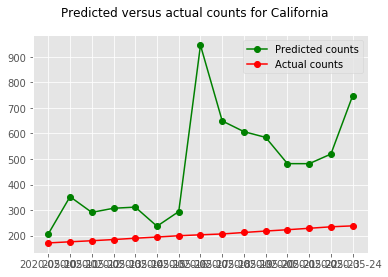

<Figure size 432x288 with 0 Axes>

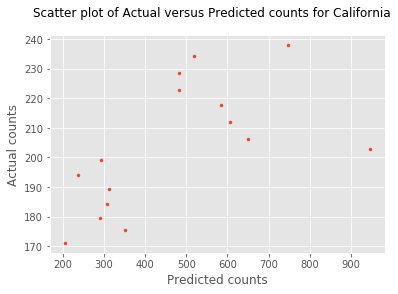

In [42]:

#Plot the predicted counts versus the actual counts for the test data for california.
fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')

plt.show()

# Negative Binomial Regression on General linear Models

In [ ]:
# INCOMPLETE
# Negative Binomial Regression from TowardsDataScience at
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['BB_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_COUNT']) / x['BB_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

#Print the regression params
print(aux_olsr_results.params)

#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

#print the training summary
print(nb2_training_results.summary())

#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)



# Multi Layer Perceptron Regressor

## We have problem with the Binomial loss

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xt, yt))

batch_size = 32

#no shuffle
# train_dataset = train_dataset.shuffle(200)
train_dataset = train_dataset.batch(batch_size)
X,y = next(iter(train_dataset))
X

<tf.Tensor: shape=(32, 4), dtype=float64, numpy=
array([[27.        , -0.6153619 , -1.62433509, -2.78111875],
       [48.        ,  0.16380336, -1.62433509, -2.11072188],
       [48.        ,  0.16380336, -1.56421571, -2.00934203],
       [48.        ,  0.16380336, -1.50409633, -1.97460725],
       [48.        ,  0.16380336, -1.44397695, -1.5295287 ],
       [32.        ,  1.78765747, -1.62433509, -1.36014191],
       [48.        ,  0.16380336, -1.38385757, -0.8831    ],
       [32.        ,  1.78765747, -1.56421571, -2.33151197],
       [48.        ,  0.16380336, -1.32373819, -1.97009169],
       [ 8.        , -0.78389125, -1.62433509, -1.84484238],
       [21.        ,  0.06471654, -1.62433509, -2.30655771],
       [32.        ,  1.78765747, -1.50409633, -2.09568061],
       [48.        ,  0.16380336, -1.2636188 , -1.93146949],
       [ 5.        , -0.09079692, -1.62433509, -2.2611713 ],
       [ 8.        , -0.78389125, -1.62433509, -1.46458267],
       [21.        ,  0.06471654, -1

In [ ]:
# INCOMPLETE
## Create the losses 

def Binomial_Loss(x,n,p):
    coeff = tf.math.lgamma(n + x) - tf.math.lgamma(x + 1) - tf.math.lgamma(n)
    return -tf.cast(tf.exp(coeff + n * tf.log(p) + x * tf.log(1 - p)),dtype=tf.float64)

loss_func = Binomial_Loss(???)

# logistic_loss = losses.BinaryCrossentropy(from_logits=True)

In [103]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_pred = model(x, training= training)

  return loss_func(y_true= y, y_pred= y_pred)

In [104]:
## Gradient tape lets TF know with respect to what to take gradients inputs = X an targets = Y
def grad(model, inputs, targets):
  with tf.GradientTape() as tape: # getting gradient tapes for the automatix differentiation
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [113]:
# the first model with relu activation function and 3 units in the hidden layer
model = Sequential([
  layers.Dense(30, input_dim = 4, activation="relu"), 
  layers.Dense(1)
])

y_pred = model(X)
print(model.summary())

print(loss(model, X, y, training= False))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 30)                150       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None
tf.Tensor(nan, shape=(), dtype=float64)


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# negative Binomial Regression from TowardsDataScience at
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

In [99]:
import tensorflow as tf
import tensorflow as tf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def gen_data(N = 10000):
    data = np.random.uniform(-1, 1, (N, 3))
    data = sm.add_constant(data)
    data = pd.DataFrame(data, columns = ['intercept', 'Var1', 'Var2', 'Var3'])
    lam = np.exp(-2*data['intercept'] + data['Var1'] - 0.5*data['Var2'] + 0.3*data['Var3'] )
    resp = np.random.poisson(lam = lam)
    data['lam'] = lam
    data['response'] = resp
    return data

dtrain = gen_data()
dtrain.drop('lam', axis=1)

X = tf.constant(dtrain[['intercept', 'Var1', 'Var2', 'Var3']].values, name = 'X', dtype=tf.float32)
# <tf.Tensor 'X:0' shape=(10000, 4) dtype=float32>

y = tf.constant(value = list(dtrain['response']), dtype = tf.float32, name='y', shape=(dtrain.shape[0], 1))
# <tf.Tensor 'y:0' shape=(10000, 1) dtype=float32>

parameters = tf.Variable(tf.zeros([4, 1])) #Initial Values
# <tf.Variable 'Variable:0' shape=(4, 1) dtype=float32_ref>

logits = tf.matmul(X, parameters, name="logits")
# <tf.Tensor 'logits:0' shape=(10000, 1) dtype=float32> 

y_hat = tf.exp(logits)

# create the loss
loss = tf.reduce_mean(-y*tf.log(y_hat)+y_hat)
# last term can be avoided since it doesn't depend on y_pred
# however keeping it gives a nice lower bound to zero
# tf.lgamma computes the log of the absolute value of Gamma(x) element-wise

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epochs = 10000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        sess.run(training_op)
        if epoch % 100 == 0:
            print("Epoch", epoch, "Loss = ", loss.eval())
    best_parameters = parameters.eval()
    
print(best_parameters)

AttributeError: module 'tensorflow' has no attribute 'log'